## <font color='Red'> BRAIN TUMOR CLASSIFIER REACHING MORE THAN 97% ACCURACY ON VALIDATION DATASET</font>

###  For further information about the notebook and the details about each step, click at the following link https://github.com/Iron486/Brain_cancer_classification and check the README.md file. In one of the notebooks, 98.2% validation accuracy was reached.

##   <font color='Aquamarine'>Import libraries</font> 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print('num of gpu available: ', len(tf.config.list_physical_devices('GPU')))

num of gpu available:  1


In [4]:
#!pip install tf-nightly
#!pip install keras_efficientnets
#!pip install pretty-confusion-matrix

In [4]:
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## <font color='Aquamarine'>Create labels</font> 

In [5]:
#create labels
classes=[]
filename='/content/drive/MyDrive/Brain mri/mri images'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']


## <font color='Aquamarine'>Resize images and put together Training and Testing folder</font> 

In [6]:
#resize images and put together Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|██████████| 74/74 [00:38<00:00,  1.90it/s]


## <font color='Aquamarine'>Data augmentation and splitting</font> 

In [10]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)
print(X_train.shape)
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

(3264, 160, 160, 3)


## <font color='Aquamarine'>Load EfficientNetB3</font> 

In [9]:
print(y_train)

#load EfficientNet
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

[3 1 1 ... 3 3 0]
43950080/43941136 [==============================] - 0s 0us/step


## <font color='Aquamarine'>Train the model</font> 

In [10]:
#train the model
tf.random.set_seed(45)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=90,
    batch_size=13,callbacks=early_stopping_cb)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0]']      

In [11]:
y_train.shape,y_test.shape

((2774,), (490,))

## <font color='Aquamarine'>Save the model</font> 

16/16 [==============================] - 1s 56ms/step - loss: 0.1580 - accuracy: 0.9592
Accuracy: 95.918369


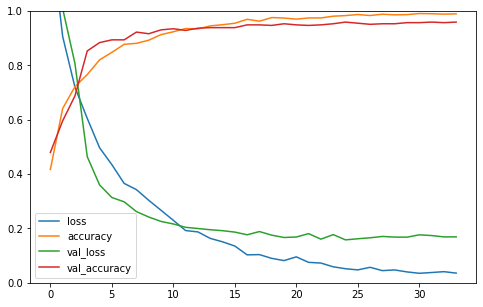

In [12]:
# change directory
#os.chdir(r'../input/brain-tumor-classification-mri')
#print(os.getcwd())

#save the model
#model.save('/kaggle/working/EfficientNetB3.h5')
#model.save_weights('/kaggle/working/EfficientNetB3_weights.h5')

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.grid(True)

#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
plt.savefig('/content/drive/MyDrive/Brain mri/EfficientNetB3.png')
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

In [13]:
 #load the model
#model=keras.models.load_model('/kaggle/working/EfficientNetB3.h5')  

#model.summary()
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 1s 44ms/step - loss: 0.1580 - accuracy: 0.9592


In [14]:

#  More details about the model

for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')


#info about optimizers
model.optimizer.get_config()  

0 <keras.engine.input_layer.InputLayer object at 0x7f55b4900690>
   no activation attribute
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f55b3f81e10>
   no activation attribute
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f55a31e5850>
   no activation attribute
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f55a31e5c90>
   no activation attribute
4 <keras.layers.convolutional.Conv2D object at 0x7f55a2904c50>
     <function linear at 0x7f55b55af200>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5644105d10>
   no activation attribute
6 <keras.layers.core.activation.Activation object at 0x7f55a2904ad0>
     <function swish at 0x7f55b55aa5f0>
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f55a0699790>
     <function linear at 0x7f55b55af200>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f55a06b3d90>
   no activation attribute
9 <keras.layers.c

{'amsgrad': False,
 'beta_1': 0.91,
 'beta_2': 0.9994,
 'decay': 0.0,
 'epsilon': 1e-08,
 'learning_rate': 1.6e-05,
 'name': 'Adam'}

## <font color='Aquamarine'>Accuracy and Loss</font> 

In [15]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 95.918 
 loss : 0.158


In [16]:

y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

## <font color='Aquamarine'>Confusion Matrix</font> 

Text(70.8, 0.5, 'Predicted class')

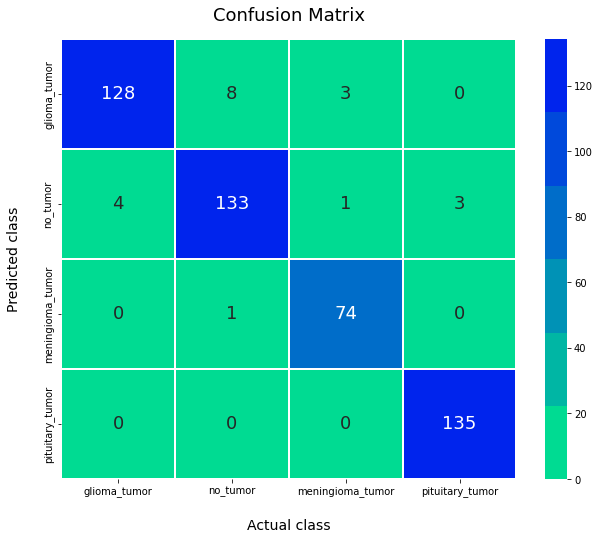

In [18]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

## <font color='Aquamarine'>Model performance scores</font> 

In [19]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.92      0.94       139
        no_tumor       0.94      0.94      0.94       141
meningioma_tumor       0.95      0.99      0.97        75
 pituitary_tumor       0.98      1.00      0.99       135

        accuracy                           0.96       490
       macro avg       0.96      0.96      0.96       490
    weighted avg       0.96      0.96      0.96       490



In [20]:
os.getcwd()

'/content'

In [21]:
import matplotlib.image as mpimg
os.chdir('/content/drive/MyDrive/Brain mri/mri images')
TEST_DIR='Testing'
#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]


Testing/meningioma_tumor
Testing/pituitary_tumor
Testing/no_tumor
Testing/glioma_tumor


ROC AUC score: 0.9744398939890533


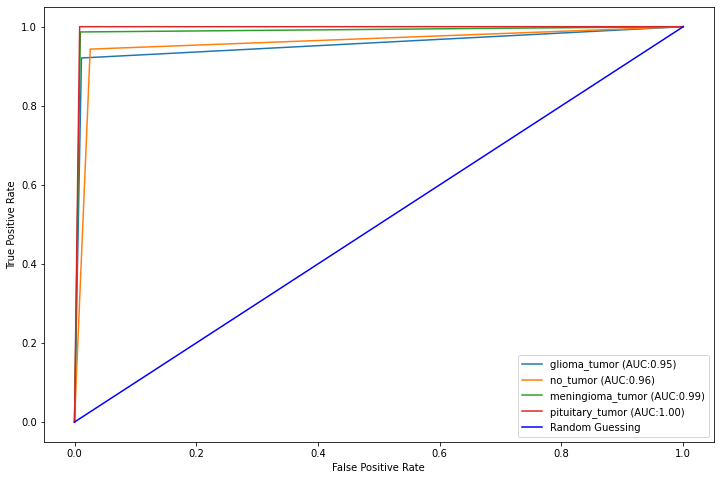

In [24]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

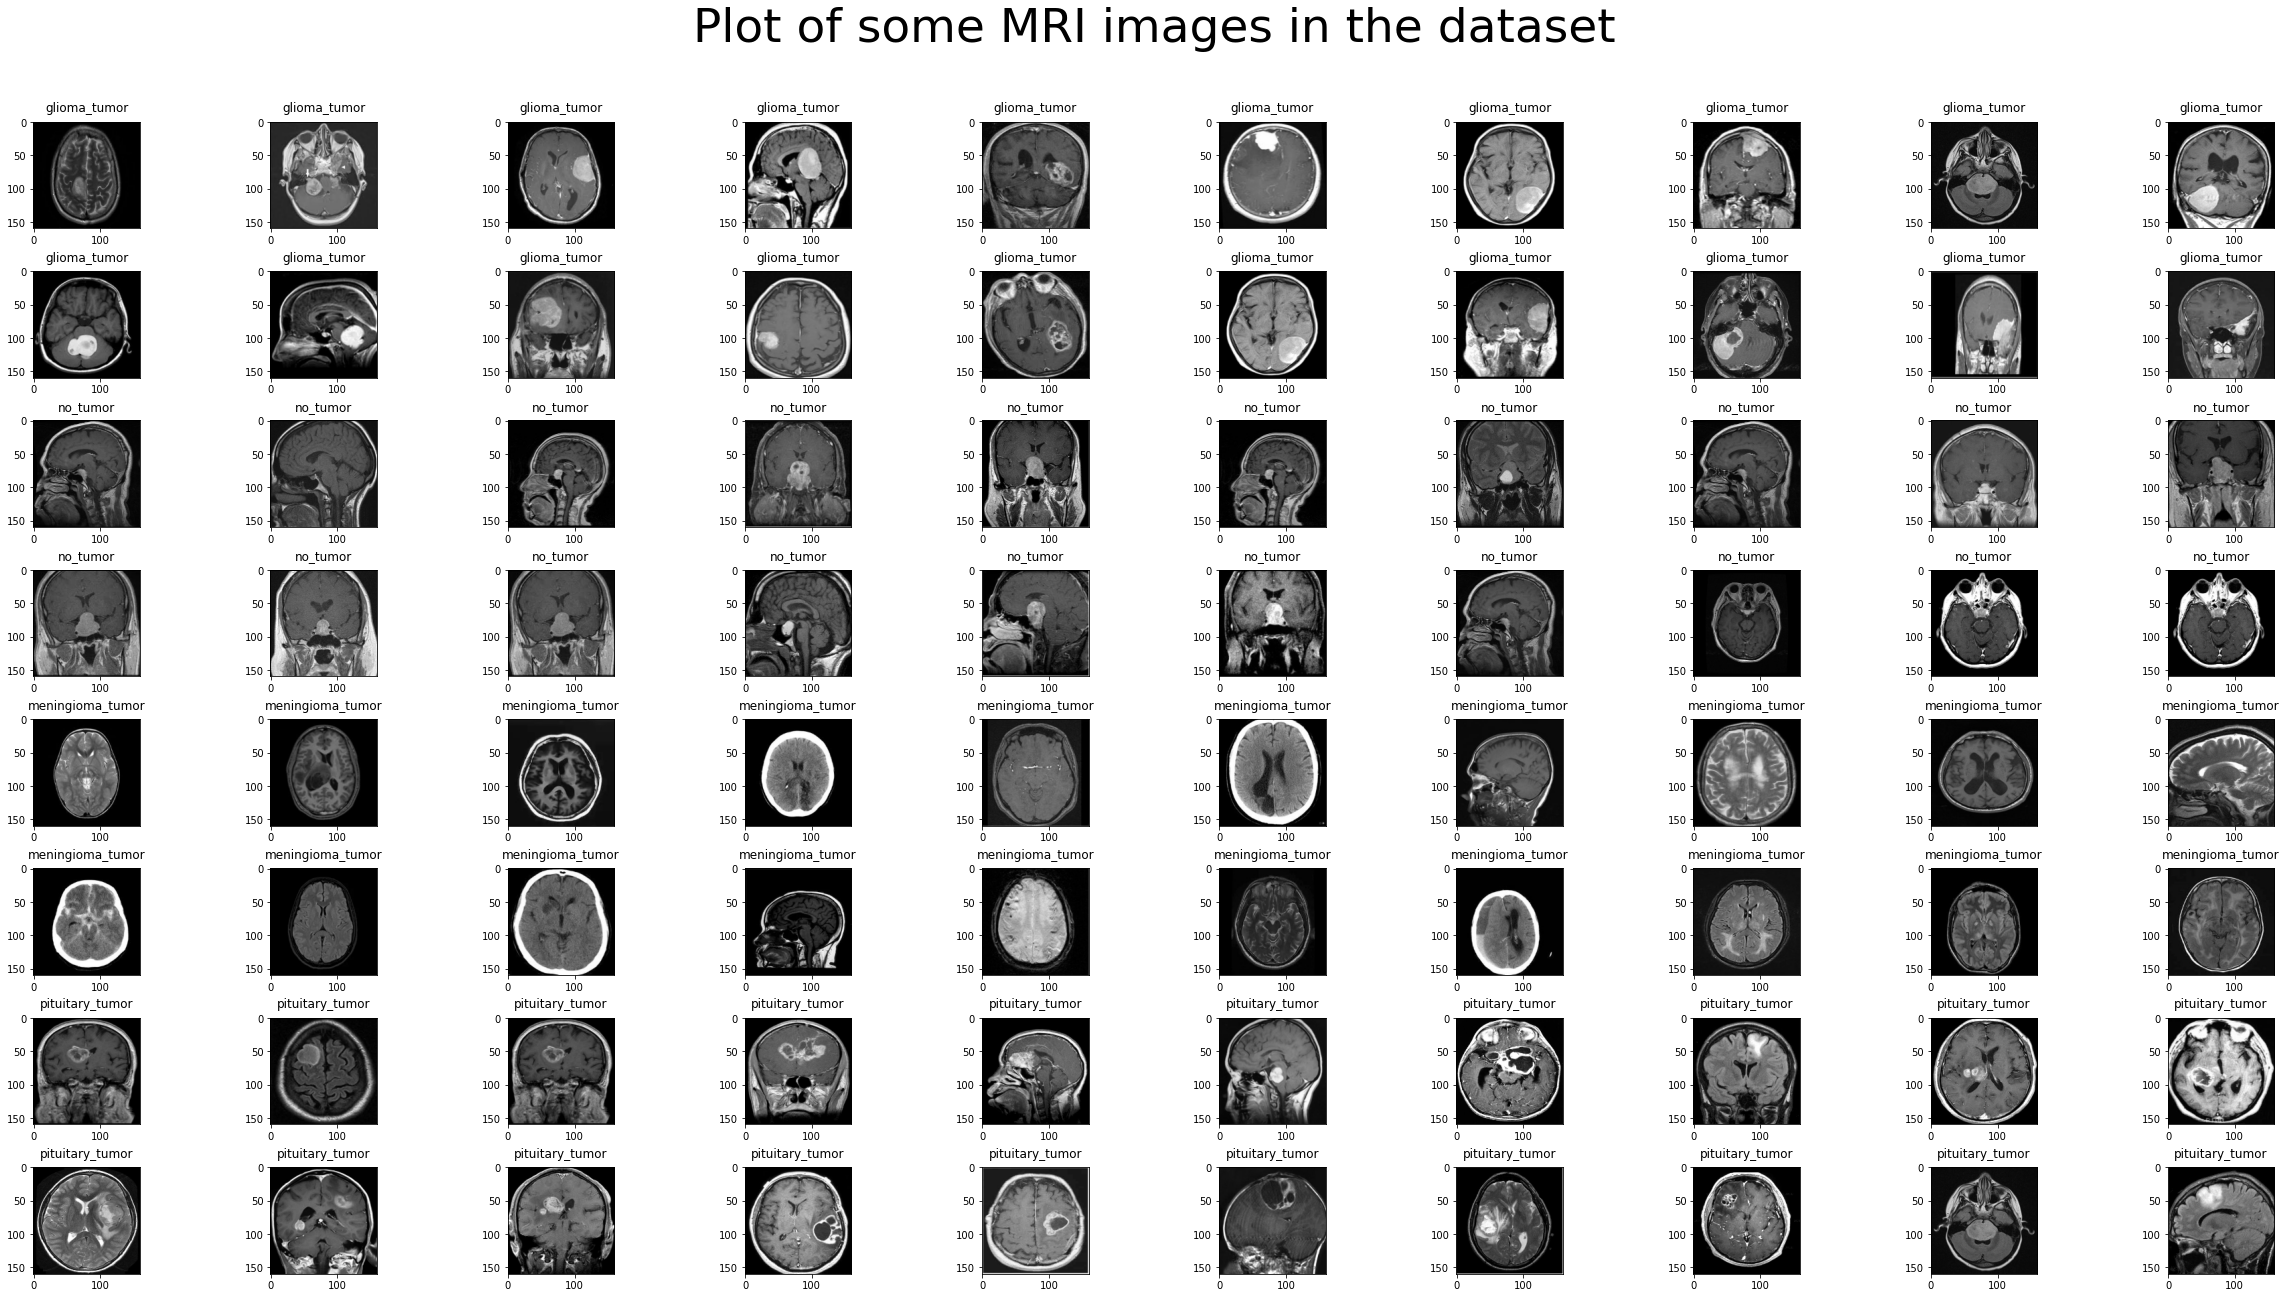

In [ ]:
#here I plotted the images based on columns and z_max (defined by the user, 
#but it should be a multiple of the # of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')

In [ ]:
X_test_images=dict(zip(classes,[[],[],[],[]]))
for y,ele in enumerate(pred):
    for i,x in enumerate(X_test_images):
        #num=pred[ind]
        if ele==i:
            if len(X_test_images[classes[i]])<z_max:
                X_test_images[classes[i]].append(X_test[y])
X_test_images=[X_test_images[i]  for i in X_test_images]


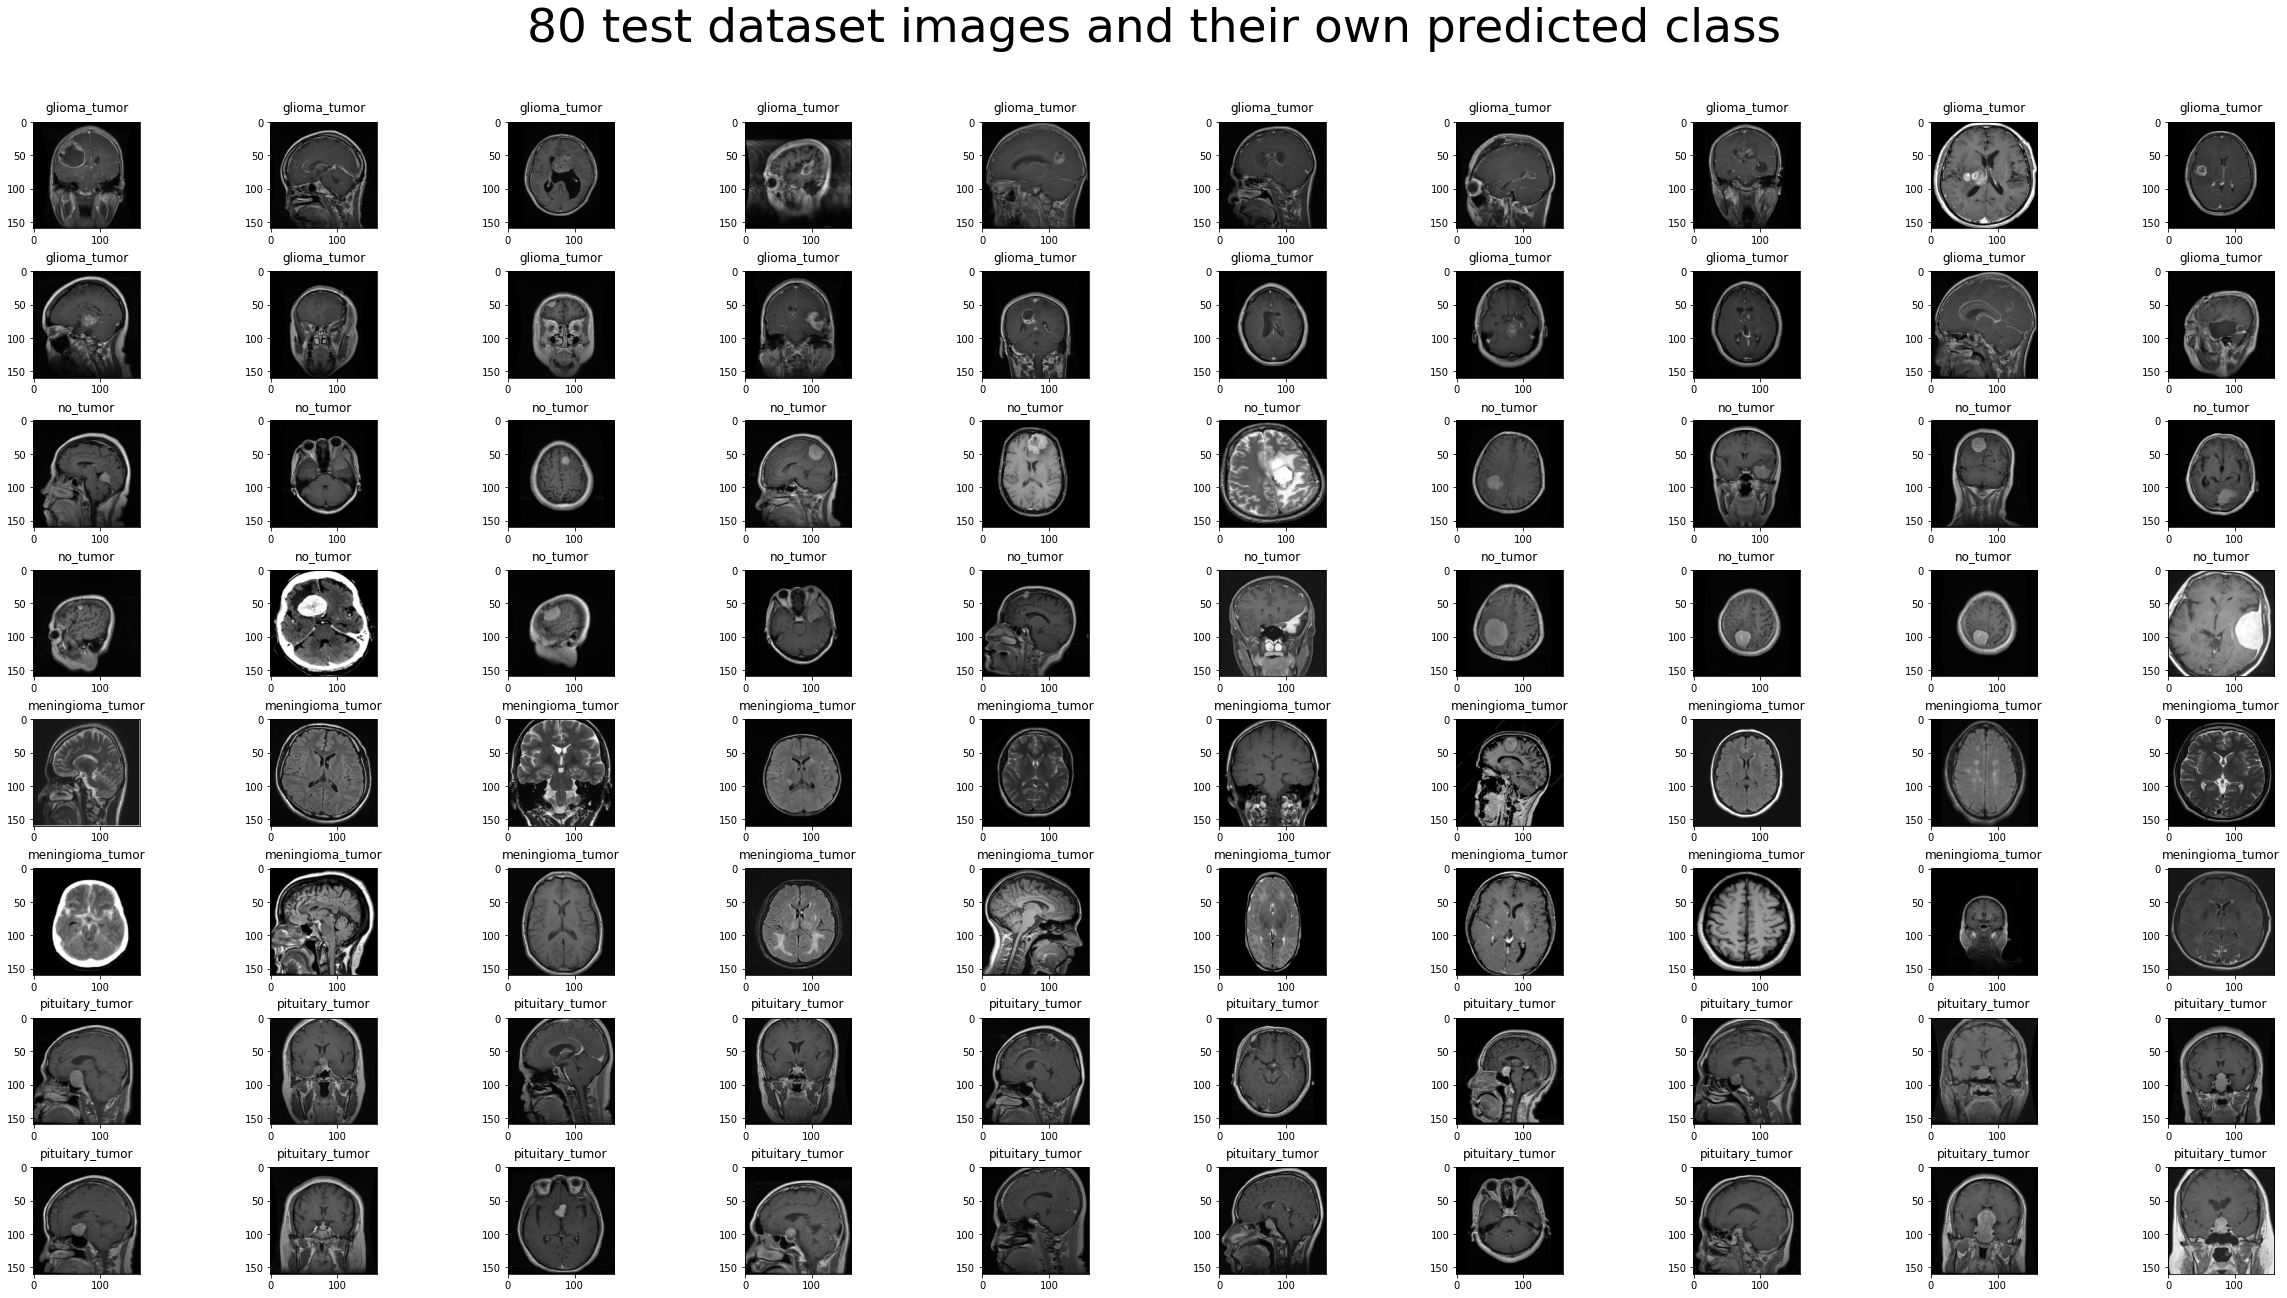

In [ ]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images)*len(X_test_images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images):
    #print(images_class)
    fig.suptitle('80 test dataset images and their own predicted class',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass.png'), dpi=300)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass_white.png'), dpi=300,facecolor='w')

In [ ]:
X_test.shape